In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
import seaborn as sns
from scipy.stats import norm
%matplotlib notebook
import matplotlib as mpl
import matplotlib.patches as patches
from datetime import datetime

## Create a hitmap that is 20*20

In [2]:
def get_gaussian_weights(value, stds):
    
    '''
    return the weights for the time, longitude, and latitude for interpolation
    Uses the Gaussian distribution 
    
    param: values = list with [longitude, latitude, time] of that point
    param: stds = list with custom stds for [time, lon, lat]
    '''
    
    lon, lat, time = tuple(value)
    lon_std, lat_std, time_std = tuple(stds)
    
    z_lon = (df['Lon'] - lon) / lon_std
    z_lat = (df['Lat'] - lat) / lat_std
    z_time = (df['secDay'] - time) / time_std
    
    # finds the weights
    w_lon = norm.pdf(z_lon)
    w_lat = norm.pdf(z_lat)
    w_time = norm.pdf(z_time)
    
    return w_lon, w_lat, w_time

In [3]:
def get_data_for_heatmap(lons, lats, time, dists, heatmap_size, col_name='sw pCO2 (uatm)', time_factor=1, size_factor=1):
    
    dist_lon, dist_lat, dist_time = tuple(dists) 
    stds=[dist_lon * size_factor, dist_lat * size_factor, dist_time * time_factor]

    data = np.zeros((heatmap_size, heatmap_size))
    for i, lat in enumerate(lats):
        
        data_arr = []
        
        for lon in lons:
            w_lon, w_lat, w_time = get_gaussian_weights((lon, lat, time), stds=stds)
            
            X = df[col_name].values
            val = np.sum(X * w_time * w_lon * w_lat) / np.sum(w_time * w_lon * w_lat)            
            data_arr.append(val)
        
        data[i, :] = data_arr
        
    return data

In [4]:
NW = (-70.14655, 43.72273)
NE = (-70.14619, 43.72253)
SE = (-70.14876, 43.72015)
SW = (-70.14911, 43.72035)
corners = [NW, NE, SE, SW]

# Displaying timeseries heatmap

In [5]:
df = pd.read_csv('FLO_L3_20170502.csv', skiprows=[1])

# filters out all the values that are -9999
df.replace(-9999, np.NaN, inplace=True)
df = df[['Lat', 'Lon', 'secDay', 'Water temp (C)', 'Salinity (PSU)', 'O2 umol/L', 'Chl a (mg/m3)', 'sw pCO2 (uatm)']]
df.dropna(inplace=True)

# filter out pCO2 values that are outliers
df = df[(df['sw pCO2 (uatm)'] > 250) & (df['sw pCO2 (uatm)'] < 370)]

# sets bounds for longitude
# df = df[df['Lon'] > -70.155]

heatmap_size = 30
# np.linspace(0, 7, 14, endpoint=False)[1::2]
time_size = 12

# to change the standard deviations
size_factor = 2
time_factor = 2

# calculates the distance of each box of the heatmap in lat/lon units
dist_lon = (df['Lon'].max() - df['Lon'].min()) / heatmap_size
dist_lat = (df['Lat'].max() - df['Lat'].min()) / heatmap_size
dist_time = (df['secDay'].max() - df['secDay'].min()) / time_size

# gets the values to interpolate from (which is the lat,lon coordinate in the middle of each box in the heatmap)
lons = np.linspace(df['Lon'].min(), df['Lon'].max(), heatmap_size * 2, endpoint=False)[1::2]
lats = np.linspace(df['Lat'].min(), df['Lat'].max(), heatmap_size * 2, endpoint=False)[1::2]
times = np.linspace(df['secDay'].min(), df['secDay'].max(), time_size * 2, endpoint=False)[1::2]



<IPython.core.display.Javascript object>


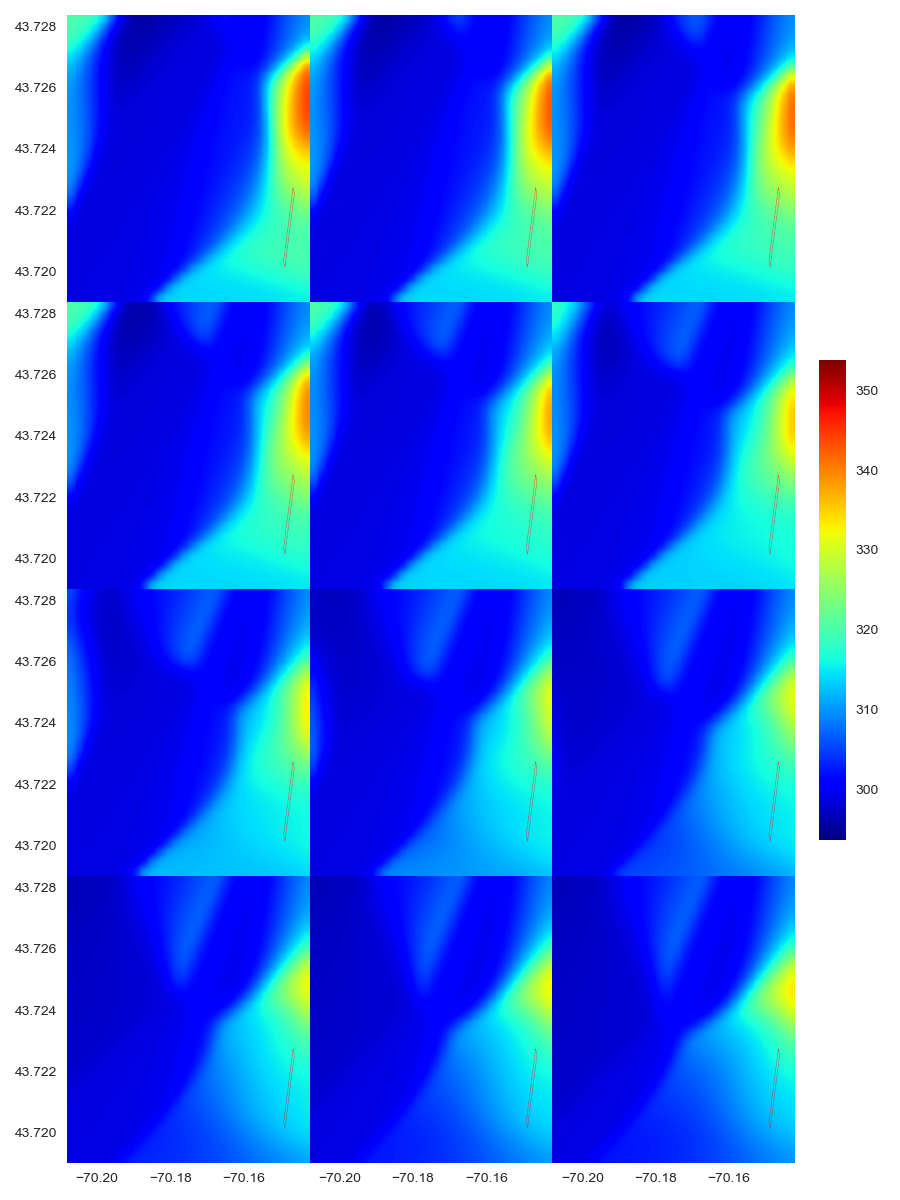

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [6]:
fig, axes = plt.subplots(4,3, figsize=(9, 12), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
extent = [df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max()]
# plt.subplots_adjust(wspace=0, hspace=0)
for i, ax in enumerate(axes.flat):
    data_arr = get_data_for_heatmap(lons, lats, times[i], (dist_lon, dist_lat, dist_time), 
                                    heatmap_size, time_factor=time_factor, size_factor=size_factor)
    im = ax.imshow(data_arr, 
                   cmap='jet', 
                   vmin = df['sw pCO2 (uatm)'].min(),
                   vmax = df['sw pCO2 (uatm)'].max(),
                   origin='lower',
                   extent=extent,
                   interpolation='gaussian')
    
#     ax.set(title='time: {}'.format(i))
    ax.set_aspect('auto')
    ax.grid(False)
    
    # adds the location of the farm
    ax.add_patch(patches.Polygon(xy=corners, fill=False, edgecolor='r', linestyle='dashed'))
    
    # turns off scientific notation
    from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
    if i == 0:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
    
    # sets the x and y axis to the boundaries of longitude and latitude
#     ax.set_xlim(df['Lon'].min(), df['Lon'].max())
#     ax.set_ylim(df['Lat'].min(), df['Lat'].max())

fig.colorbar(im, ax=axes.ravel().tolist(), cax=cbar_ax)
fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0, hspace=0)

In [7]:
# import matplotlib as mpl

# # creates a color array
# data = df['sw pCO2 (uatm)']
# normal = mpl.colors.Normalize()
# normal.autoscale(data)
# rgba_colors = plt.cm.jet(normal(data))
# alphas = norm.pdf(df['secDay'], times[3], dist_time / 2)
# rgba_colors[:, 3] = alphas / alphas.max()

In [8]:
# fig, ax = plt.subplots()
# data_arr = get_data_for_heatmap(lons, lats, times[3], (dist_lon, dist_lat, dist_time), 
#                                 heatmap_size, time_factor=time_factor, size_factor=size_factor)
# extent = [df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max()]
# im = ax.imshow(data_arr, 
#                cmap = 'Greys', 
#                vmin = df['sw pCO2 (uatm)'].min(),
#                vmax = df['sw pCO2 (uatm)'].max(),
#                origin = 'lower',
#                interpolation = 'gaussian',
#                extent = extent)
# ax.set_aspect('auto')

# ax.grid(False)
# ax.figure.colorbar(im)


# # draws the scatterplot on top
# ax.scatter(df['Lon'], df['Lat'], c=rgba_colors, s=10)

In [9]:
# to change the standard deviations
size_factor = 2
time_factor = 2

<IPython.core.display.Javascript object>


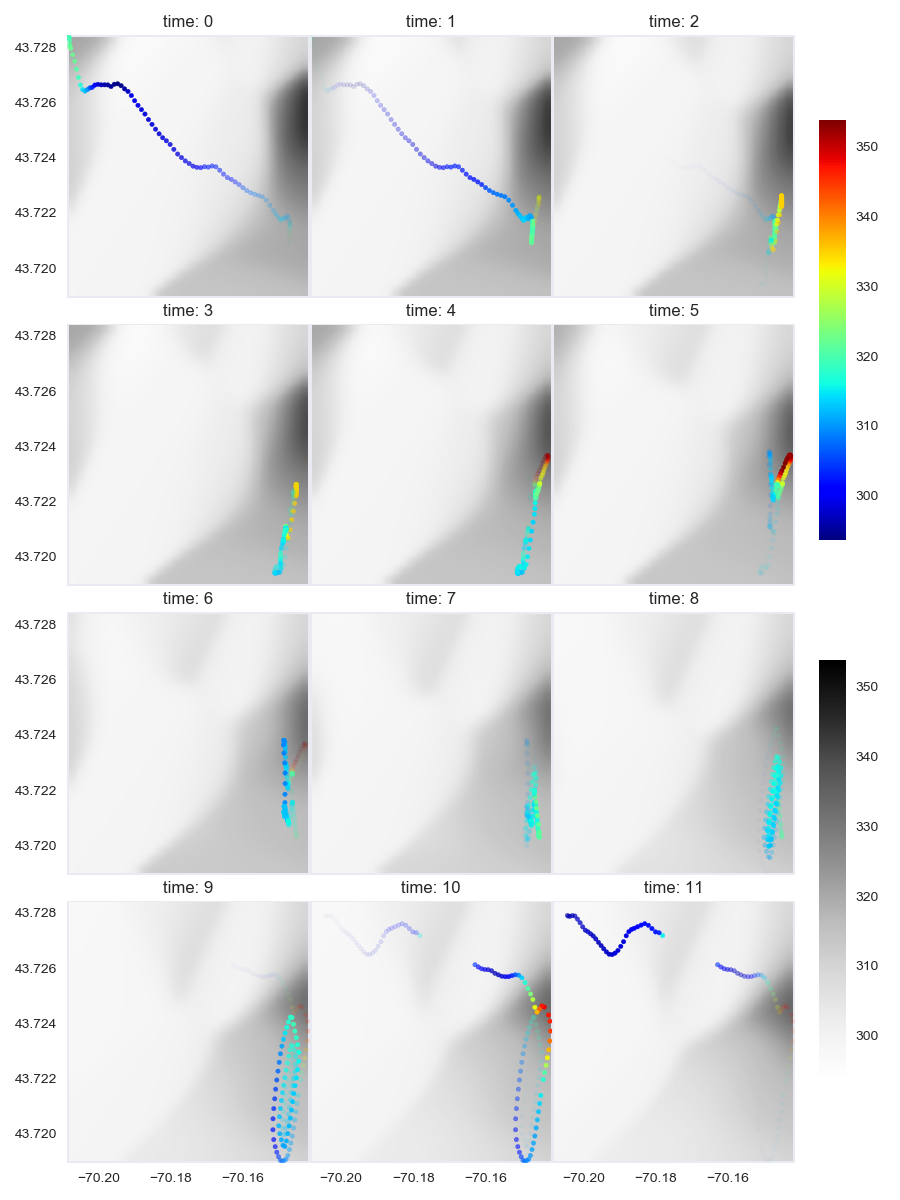

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [10]:
# creates a color array for jet colorscale
data = df['sw pCO2 (uatm)']
color_normal = mpl.colors.Normalize()
color_normal.autoscale(data)
cm = plt.cm.get_cmap('jet')
rgba_colors = cm(color_normal(data.values))

# sets the x and y axis to the boundaries of longitude and latitude
extent = [df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max()]


fig, axes = plt.subplots(4,3, figsize=(9, 12), sharex=True, sharey=True)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax1 = fig.add_axes([.91, .1, .03, .35])
cbar_ax2 = fig.add_axes([.91, .55, .03, .35])

for i, ax in enumerate(axes.flat):
    data_arr = get_data_for_heatmap(lons, lats, times[i], (dist_lon, dist_lat, dist_time), 
                                    heatmap_size, time_factor=time_factor, size_factor=size_factor)
    im = ax.imshow(data_arr, 
               cmap = 'Greys', 
               vmin = df['sw pCO2 (uatm)'].min(),
               vmax = df['sw pCO2 (uatm)'].max(),
               origin = 'lower',
               interpolation = 'gaussian',
               extent = extent)
    ax.set_aspect('auto')

    ax.grid(False)
    
    ax.set(title='time: {}'.format(i))
    
    alphas = norm.pdf(df['secDay'], times[i], dist_time / 2)
    rgba_colors[:, 3] = alphas / alphas.max()
    scat = ax.scatter(df['Lon'], df['Lat'], c=rgba_colors, s=10)
    
    # turns off scientific notation
    from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
    if i == 0:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
fig.colorbar(im, ax=axes.ravel().tolist(), cax=cbar_ax1)
mpl.colorbar.ColorbarBase(cbar_ax2, cmap=cm, norm=color_normal)
fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0, hspace=0.1)

# Zooming in

### Gets the tides data

In [11]:
tides_df = pd.read_csv('Tidal_Current Data/CAB1409_prediction_Timeseries_2017-05-02_cleaned.csv')
X = np.array([int(datetime.strptime(x, '%Y-%m-%d %I:%M:%S %p').strftime('%s')) 
              for x in tides_df['Date_Time (GMT)']])
X = X - X.min() # subtracts the min
y = tides_df['Speed (cm/sec)'].values
X_pred = df['secDay'].values
y_pred = np.interp(X_pred, X, y)

In [12]:
# filter out noisy data
df = df[(df['sw pCO2 (uatm)'] > 100) & (df['sw pCO2 (uatm)'] < 600)]

In [13]:
def get_boundary_box(corners, R=6378137):
    '''
    Corners follow the order NW, NE, SE, SW, (longitude, latitude)
    
    returns: upperbound, lower bound, right bound, left bound
    '''
    northmost = max(corners, key=lambda x: x[0])
    southmost = min(corners, key=lambda x: x[0])
    eastmost = max(corners, key=lambda x: x[1])
    westmost = min(corners, key=lambda x: x[1])  
    
    def get_coords_from_offsets(dn, de, coord):
        
        lon, lat = coord
        
        #Coordinate offsets in radians
        dLat = dn/R
        dLon = de/(R*np.cos(np.pi*lat/180))

        #//OffsetPosition, decimal degrees
        latO = lat + dLat * 180/np.pi
        lonO = lon + dLon * 180/np.pi 
        return (lonO, latO)
    
    # offsets in meters for north
    dn = 300
    de = 0
    
    _, north_lat = get_coords_from_offsets(dn, de, northmost)
    
    # offsets in meters for south
    dn = -300
    de = 0
    
    _, south_lat = get_coords_from_offsets(dn, de, southmost)
    
    # offsets in meters for east
    dn = 0
    de = 300
    
    east_lon, _ = get_coords_from_offsets(dn, de, eastmost)
    
    # offsets in meters for east
    dn = 0
    de = -300
    
    west_lon, _ = get_coords_from_offsets(dn, de, westmost)
    
#     corners = [(west_lon, north_lat), (east_lon, north_lat), (west_lon, south_lat), (east_lon, south_lat)]
    
    return [north_lat, south_lat, east_lon, west_lon]

In [14]:
# bounds the graph within 300 meters of the farm

boundary = get_boundary_box(corners)
boundary

df = df[(df['Lat'] < boundary[0]) & 
        (df['Lat'] > boundary[1]) & 
        (df['Lon'] < boundary[2]) & 
        (df['Lon'] > boundary[3])]

In [15]:
# reinitialize parameters

heatmap_size = 30
# np.linspace(0, 7, 14, endpoint=False)[1::2]
time_size = 12

# to change the standard deviations
size_factor = 2
time_factor = 2

# calculates the distance of each box of the heatmap in lat/lon units
dist_lon = (df['Lon'].max() - df['Lon'].min()) / heatmap_size
dist_lat = (df['Lat'].max() - df['Lat'].min()) / heatmap_size
dist_time = (df['secDay'].max() - df['secDay'].min()) / time_size

# gets the values to interpolate from (which is the lat,lon coordinate in the middle of each box in the heatmap)
lons = np.linspace(df['Lon'].min(), df['Lon'].max(), heatmap_size * 2, endpoint=False)[1::2]
lats = np.linspace(df['Lat'].min(), df['Lat'].max(), heatmap_size * 2, endpoint=False)[1::2]
times = np.linspace(df['secDay'].min(), df['secDay'].max(), time_size * 2, endpoint=False)[1::2]

<IPython.core.display.Javascript object>


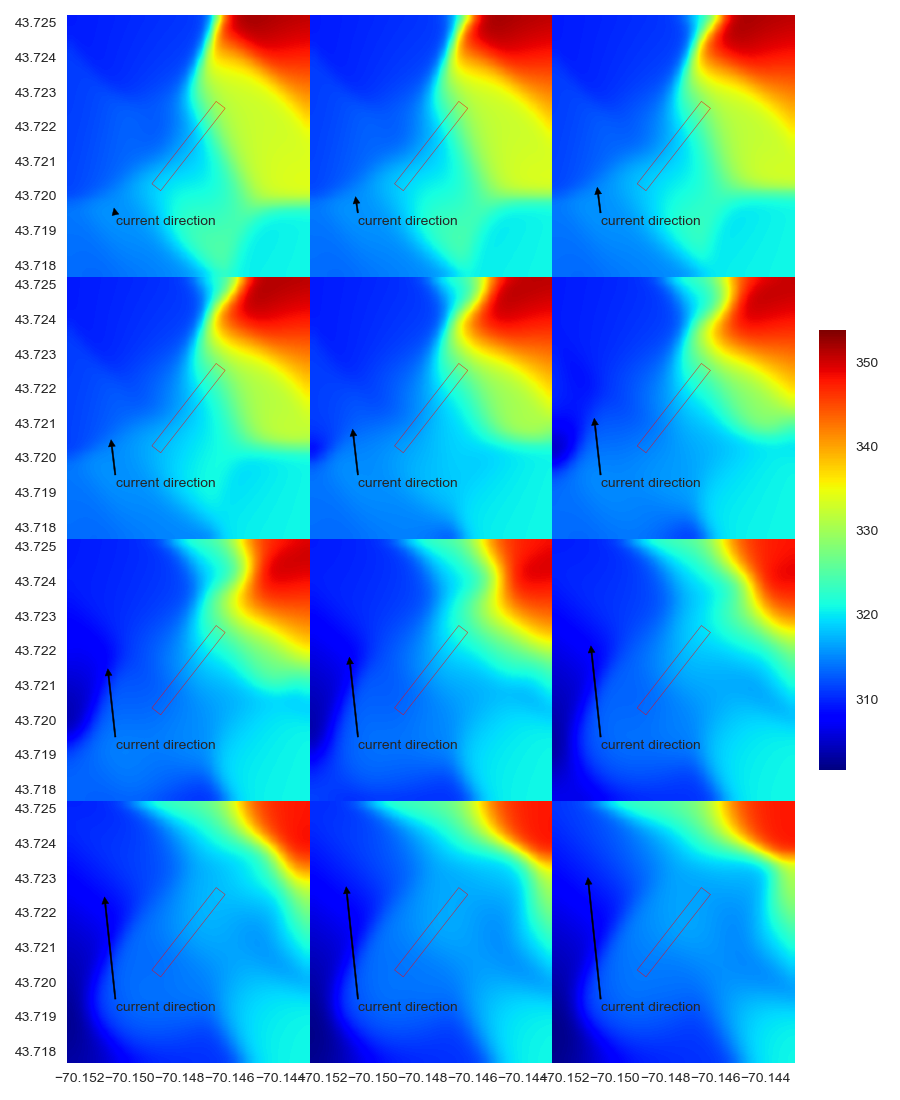

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [16]:
fig, axes = plt.subplots(4,3, figsize=(9, 11), sharex=True, sharey=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])
# extent = [df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max()]
extent = [boundary[3], boundary[2], boundary[1], boundary[0]]
# plt.subplots_adjust(wspace=0, hspace=0)
for i, ax in enumerate(axes.flat):
    data_arr = get_data_for_heatmap(lons, lats, times[i], (dist_lon, dist_lat, dist_time), 
                                    heatmap_size, time_factor=time_factor, size_factor=size_factor)
    im = ax.imshow(data_arr, 
                   cmap='jet', 
                   vmin = df['sw pCO2 (uatm)'].min(),
                   vmax = df['sw pCO2 (uatm)'].max(),
                   origin='lower',
                   extent=extent,
                   interpolation='gaussian')
    
#     ax.set(title='time: {}'.format(i))
    ax.set_aspect('auto')
    ax.grid(False)
    
    # adds the location of the farm
    ax.add_patch(patches.Polygon(xy=corners, fill=False, edgecolor='r'))
    
    # turns off scientific notation
    from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
    if i == 0:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
        
    # adds direction of current
    direction = np.deg2rad(354)
    r = 0.1 * np.sqrt(np.abs(np.interp(times[i], X, y)))  # this is the current. The bigger the current, the bigger the 
    
    center = (0.2, 0.2)
    new_center = (r * np.sin(direction) + center[0], r * np.cos(direction) + center[1]) 

    ax.annotate('current direction', xy=new_center, xytext=center, xycoords='axes fraction',
                arrowprops=dict(facecolor='black', width=1, headwidth=5, headlength=5))
#     ax.annotate('df', xy=(0.5, 0.5), xycoords='axes fraction')
    
    
    
    # sets the x and y axis to the boundaries of longitude and latitude
#     ax.set_xlim(df['Lon'].min(), df['Lon'].max())
#     ax.set_ylim(df['Lat'].min(), df['Lat'].max())

fig.colorbar(im, ax=axes.ravel().tolist(), cax=cbar_ax)
fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0, hspace=0)

In [17]:
df.shape

(443, 8)

<IPython.core.display.Javascript object>


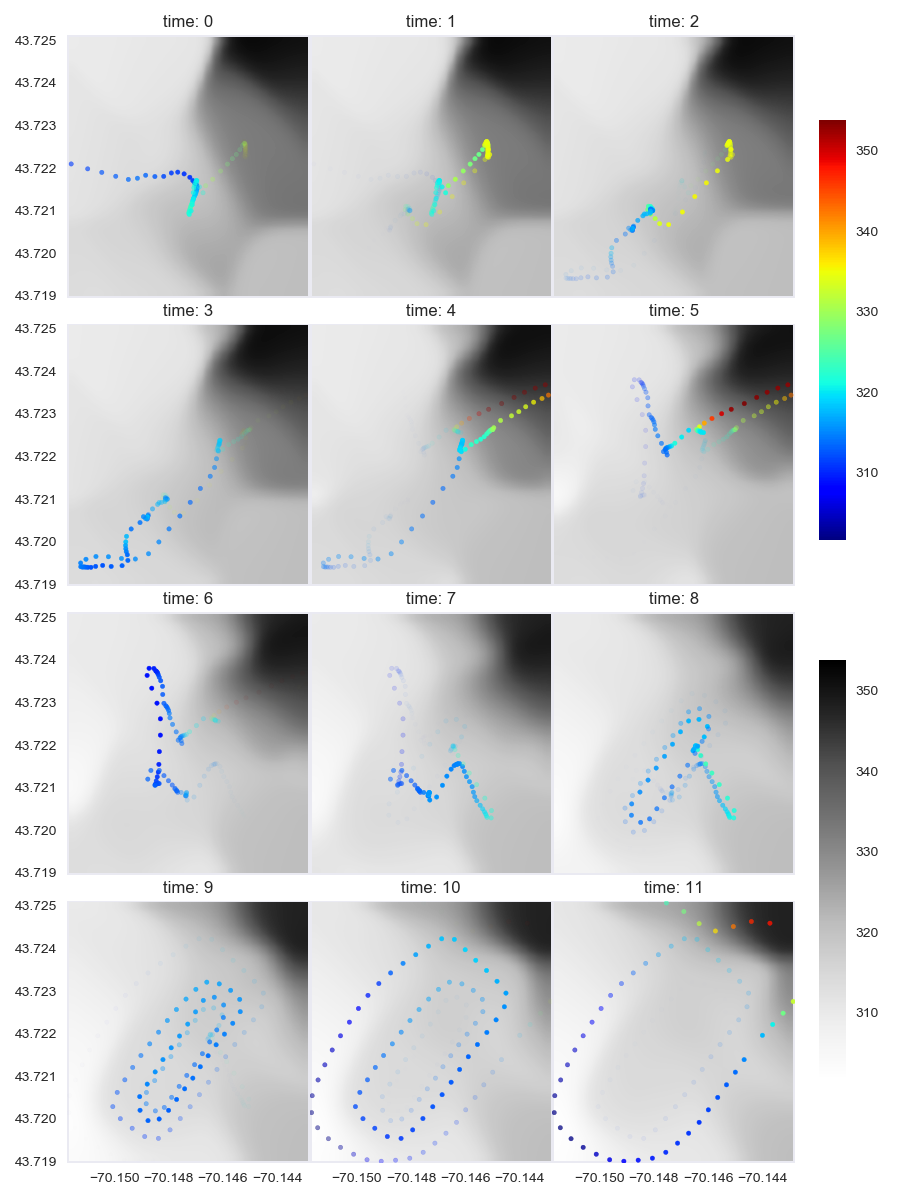

/Users/Mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [18]:
# creates a color array for jet colorscale
data = df['sw pCO2 (uatm)']
color_normal = mpl.colors.Normalize()
color_normal.autoscale(data)
cm = plt.cm.get_cmap('jet')
rgba_colors = cm(color_normal(data.values))

# sets the x and y axis to the boundaries of longitude and latitude
extent = [df['Lon'].min(), df['Lon'].max(), df['Lat'].min(), df['Lat'].max()]


fig, axes = plt.subplots(4,3, figsize=(9, 12), sharex=True, sharey=True)
# cbar_ax = fig.add_axes([.91, .3, .03, .4])
cbar_ax1 = fig.add_axes([.91, .1, .03, .35])
cbar_ax2 = fig.add_axes([.91, .55, .03, .35])

for i, ax in enumerate(axes.flat):
    data_arr = get_data_for_heatmap(lons, lats, times[i], (dist_lon, dist_lat, dist_time), 
                                    heatmap_size, time_factor=time_factor, size_factor=size_factor)
    im = ax.imshow(data_arr, 
               cmap = 'Greys', 
               vmin = df['sw pCO2 (uatm)'].min(),
               vmax = df['sw pCO2 (uatm)'].max(),
               origin = 'lower',
               interpolation = 'gaussian',
               extent = extent)
    ax.set_aspect('auto')

    ax.grid(False)
    
    ax.set(title='time: {}'.format(i))
    
    alphas = norm.pdf(df['secDay'], times[i], dist_time / 2)
    rgba_colors[:, 3] = alphas / alphas.max()
    scat = ax.scatter(df['Lon'], df['Lat'], c=rgba_colors, s=10)
    
    # turns off scientific notation
    from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
    if i == 0:
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    
fig.colorbar(im, ax=axes.ravel().tolist(), cax=cbar_ax1)
mpl.colorbar.ColorbarBase(cbar_ax2, cmap=cm, norm=color_normal)
fig.tight_layout(rect=[0, 0, 0.9, 1])
plt.subplots_adjust(wspace=0, hspace=0.1)

# Animation

In [19]:
import matplotlib.animation as animation

In [20]:
total_time = 16  # number of frames
heatmap_size = 20 # number of frames to segregate the heatmaps

# to change the standard deviations
size_factor = 1
time_factor = 1


vmin = df['sw pCO2 (uatm)'].min()
vmax = df['sw pCO2 (uatm)'].max()
lon_min = df['Lon'].min()
lon_max = df['Lon'].max()
lat_min = df['Lat'].min()
lat_max = df['Lat'].max()

# calculates the distance of each box of the heatmap in lat/lon units
dist_lon = (df['Lon'].max() - df['Lon'].min()) / heatmap_size
dist_lat = (df['Lat'].max() - df['Lat'].min()) / heatmap_size
dist_time = (df['secDay'].max() - df['secDay'].min()) / time_size

# gets the values to interpolate from (which is the lat,lon coordinate in the middle of each box in the heatmap)
lons = np.linspace(df['Lon'].min(), df['Lon'].max(), heatmap_size * 2, endpoint=False)[1::2]
lats = np.linspace(df['Lat'].min(), df['Lat'].max(), heatmap_size * 2, endpoint=False)[1::2]
times = np.linspace(df['secDay'].min(), df['secDay'].max(), total_time * 2, endpoint=False)[1::2]

In [21]:
extent = [boundary[3], boundary[2], boundary[1], boundary[0]]
def update(curr):
    
    '''
    params: col_name
    params: data: the data of interest for the heatmap
    params: total_time: the number of frames to show
    '''
    
    # check if animation is at the last frame, and if so, stop the animation a    
    
    if curr == total_time - 1:
        a.event_source.stop()
    
    plt.cla()
    ax = plt.gca()
    
    # creates a color array
    data_arr = get_data_for_heatmap(lons, lats, times[curr], (dist_lon, dist_lat, dist_time), 
                                    heatmap_size, time_factor=time_factor, size_factor=size_factor)
    im = ax.imshow(data_arr, 
                   cmap='jet', 
                   vmin = vmin,
                   vmax = vmax,
                   origin='lower',
                   extent=extent,
                   interpolation='gaussian')
    
#     ax.set(title='time: {}'.format(i))
    ax.set_aspect('auto')
    ax.grid(False)
    
    # adds title and labels
    ax.set_title('\ntime: {}'.format(curr + 1))   
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    # adds the location of the farm
    ax.add_patch(patches.Polygon(xy=corners, fill=False, edgecolor='r'))
    
    plt.tight_layout()


<IPython.core.display.Javascript object>


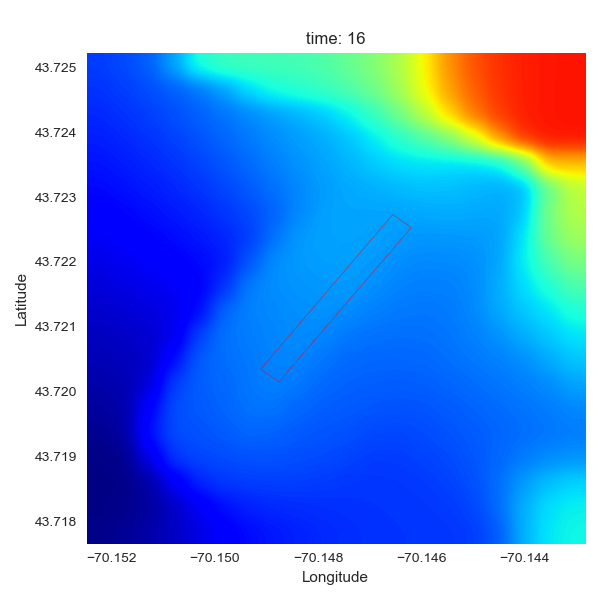

In [29]:
fig, ax = plt.subplots(figsize=(6,6))

ax.set_xlim(df['Lon'].min(), df['Lon'].max())
ax.set_ylim(df['Lat'].min(), df['Lat'].max())
ax.set_title('time: 0')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_aspect('auto')
# plt.gca().set_ylabel('Longitude')
# plt.gca().set_xlabel('Latitude')


data = np.linspace(vmin, vmax, 100).reshape(10, 10)
im = ax.imshow(data, cmap='jet')
plt.cla()
# cbar = fig.colorbar(im)

# cbar.set_label(r'{}'.format('sw pCO2 (uatm)'), rotation=90, labelpad=20)

plt.tight_layout()

a = animation.FuncAnimation(fig, update, interval=750, frames=500, repeat=False)

In [23]:
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=3, metadata=dict(artist='Me'))
# a.save('May_bilateral.mp4', writer=writer)